# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, February 15, 2017

In [1]:
%matplotlib inline 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

In [2]:
import matplotlib

In [3]:
numpy.random.seed(1234)

## 1. Data Preparation

In [4]:
from sklearn.datasets import make_blobs
n_dim = 2
x_train, y_train = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1]], shuffle=True)
x_test, y_test = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1]], shuffle=True)

In [5]:
y_train = (y_train * 2) - 1
y_test = (y_test * 2) - 1

# Why are we doing this?
# Change output from {0, 1} to {-1, 1}

## 2. Model Definition

In [6]:
'''
Definition of the SVM model.

INPUT: Feature vector (x) and weight vector (w)
OUTPUT: The class to which each data point belongs to.
'''

def svm(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return numpy.sign(y)

In [7]:
'''
Distance function of the SVM model (popularly called Hinge Loss). 

INPUT: True labels (y), feature vector (x), weight vector (w) and constant (C)
OUTPUT: Hinge loss distance values.
'''

def svm_dist(y, x, w, C, avg=False, pre=False):
    y_ = svm(x, w, pre=True)   # y_ = w.x
    
    if pre:
        return 1. - y_ * y # Margin
    
    d = numpy.maximum(0., 1. - y_ * y)  # Hinge loss
    
    if not avg:
        return d
    
    return numpy.sum(d) + (C / 2.) * numpy.sum(w**2)

In [8]:
'''
Let's use Autograd!
'''

def cost(w, x, y, C):
    return svm_dist(y, x, w, C, avg=True)

svm_rule = grad(cost)

In [9]:
def _svm_dist(w, x, y, C, avg=False):
    return svm_dist(y, x, w, C, avg=avg), svm_rule(w, x, y, C)

## 3. Training Procedure

In [40]:
w0 = 1e-4 * npr.randn(n_dim+1); w0[-1] = 0.
w = numpy.copy(w0)

res = scipy.optimize.minimize(_svm_dist, w0, (x_train, y_train, 1, True), 
                              method='L-BFGS-B', jac=True, options={'maxls': 100})   # maxls = ?

In [41]:
print (res)
w = res.x

      fun: 10.853218246574537
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.48075145,  0.10742705,  0.24566463])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 107
      nit: 21
   status: 0
  success: True
        x: array([-1.95032721, -0.7210859 ,  0.24566463])


In [42]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
#     plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == -1 else c+'+')
#     plot.hold('off')
    plot.grid('on')

In [43]:
def vis_hyperplane(w, typ='k--'):
#     plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + w[-1])/w[1]
    intercept1 = -(w[0] * m1 + w[-1])/w[1]
    
    plt1, = plot.plot([m0, m1], [intercept0, intercept1], typ)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
#     plot.hold('off')
    
    return plt1

In [44]:
def vis_sv(w):
    d = svm_dist(y_train, x_train, w, 1, pre=True)  # What values will 'd' have?
                                                    # Misclassification if positive
    
#     plot.hold('on')
    
    for dd, xx in zip(d, x_train):
        if dd >= 0.:
            plot.plot(xx[0], xx[1], '*')
    
#     plot.hold('off')

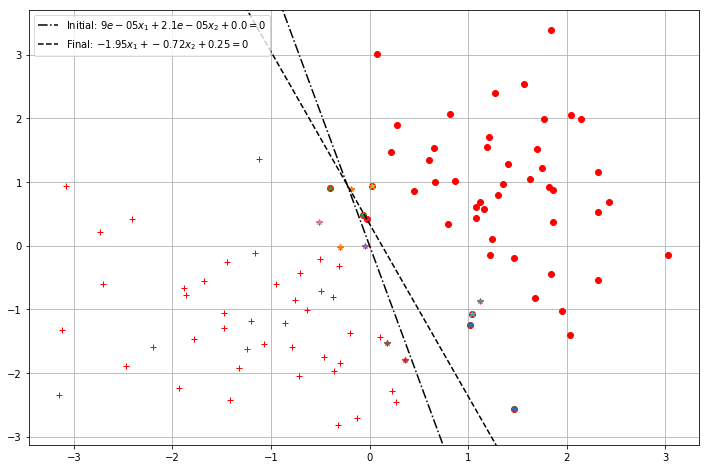

In [45]:
plot.figure(figsize=(12, 8))

vis_data(x_train, y_train, c='r')
vis_sv(w)   # What is happening inside this function?

plt0 = vis_hyperplane(w0, 'k-.')
plt1 = vis_hyperplane(w, 'k--')
plot.legend([plt0, plt1], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)),
        'Final: ${:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0$'.format(*list(w))],
           loc='best')

plot.show()

## 4. Testing

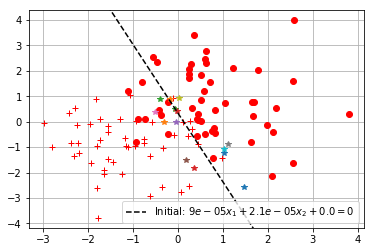

In [46]:
plot.figure()

vis_data(x_test, y_test, c='r')
vis_sv(w)   # What is happening inside this function?

plt1 = vis_hyperplane(w, 'k--')
plot.legend([plt1], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)),
        'Final: ${:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0$'.format(*list(w))],
           loc='best')

plot.show()

In [47]:
train_error = numpy.sum(numpy.abs(svm(x_train, w) - y_train)) / numpy.float(len(y_train))
test_error = numpy.sum(numpy.abs(svm(x_test, w) - y_test)) / numpy.float(len(y_test))

print 'Training error rate {}, Test error rate {}'.format(train_error, test_error)

Training error rate 0.1, Test error rate 0.26
